In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [8]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [11]:
#read data
catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

/tmp/ipykernel_132322/3461106580.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)


In [12]:
catfish_sales.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [15]:
catfish_sales.dtypes

Total    int64
dtype: object

In [16]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [42]:
catfish_sales

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


In [17]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

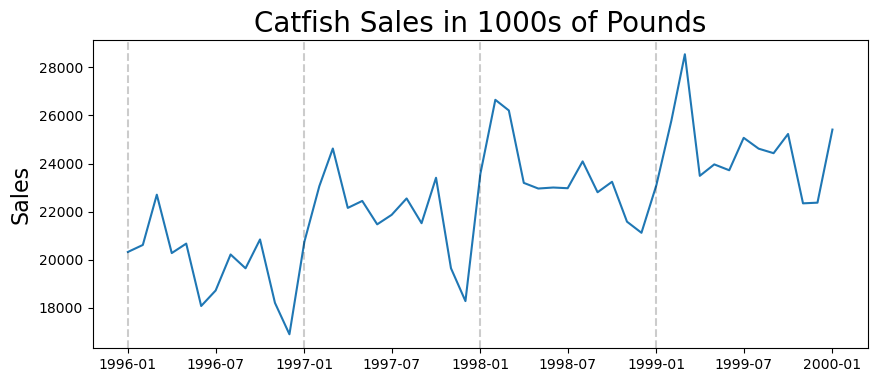

In [18]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [19]:
first_diff = lim_catfish_sales.diff()[1:]

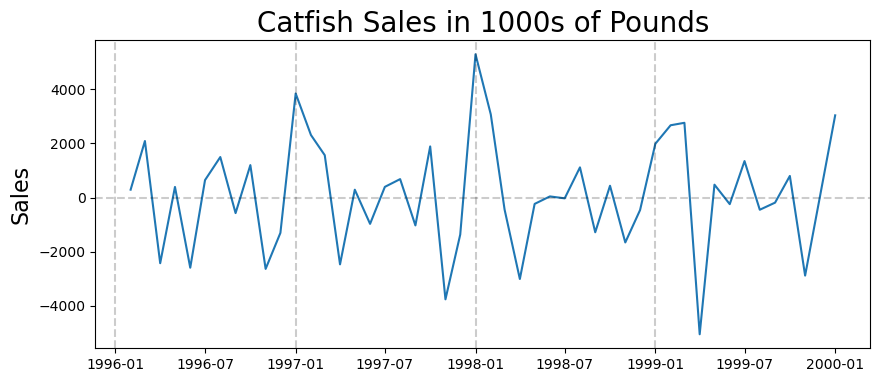

In [20]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

<BarContainer object of 17 artists>

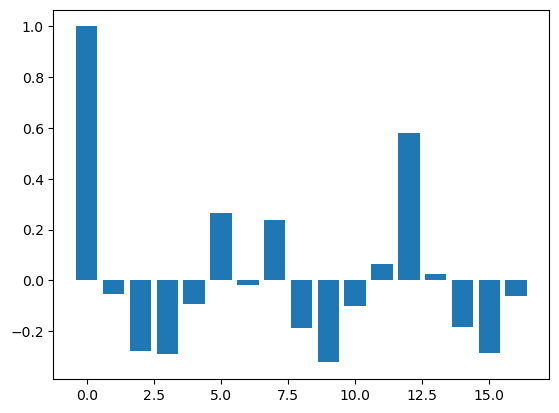

In [21]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

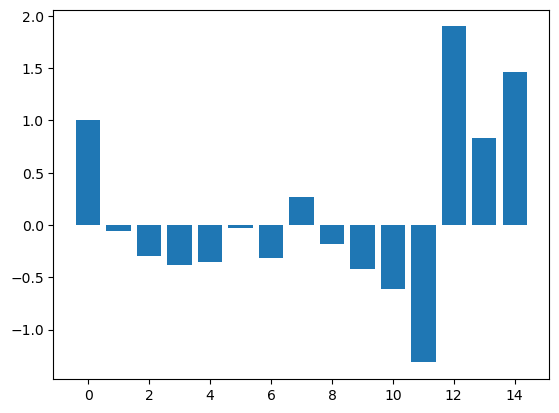

In [22]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [23]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [24]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [25]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88111D+00    |proj g|=  1.26626D+00

At iterate    5    f=  8.57512D+00    |proj g|=  3.01676D-01

At iterate   10    f=  8.55001D+00    |proj g|=  1.38247D-03

At iterate   15    f=  8.55001D+00    |proj g|=  1.09204D-03

At iterate   20    f=  8.54985D+00    |proj g|=  1.51809D-02

At iterate   25    f=  8.54232D+00    |proj g|=  1.11473D-01

At iterate   30    f=  8.51785D+00    |proj g|=  1.03001D-02

At iterate   35    f=  8.51071D+00    |proj g|=  1.52217D-01

At iterate   40    f=  8.50313D+00    |proj g|=  9.28004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [26]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Mon, 19 May 2025   AIC                            737.269
Time:                                      14:55:38   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [27]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['Total'], dtype='object')
            Total
Date             
1999-08-01  24618
1999-09-01  24430
1999-10-01  25229
1999-11-01  22344
1999-12-01  22372


In [28]:
# Assuming test_data is a DataFrame with a single column named "Total"
test_series = test_data['Total']  

In [29]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [30]:
predictions

Date
1999-08-01    25695.477303
1999-09-01    25054.188123
1999-10-01    25642.858595
1999-11-01    24195.593401
1999-12-01    23677.341665
2000-01-01    26250.597178
Freq: MS, Name: predicted_mean, dtype: float64

In [31]:
residuals	

Date
1999-08-01   -1077.477303
1999-09-01    -624.188123
1999-10-01    -413.858595
1999-11-01   -1851.593401
1999-12-01   -1305.341665
2000-01-01    -838.597178
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

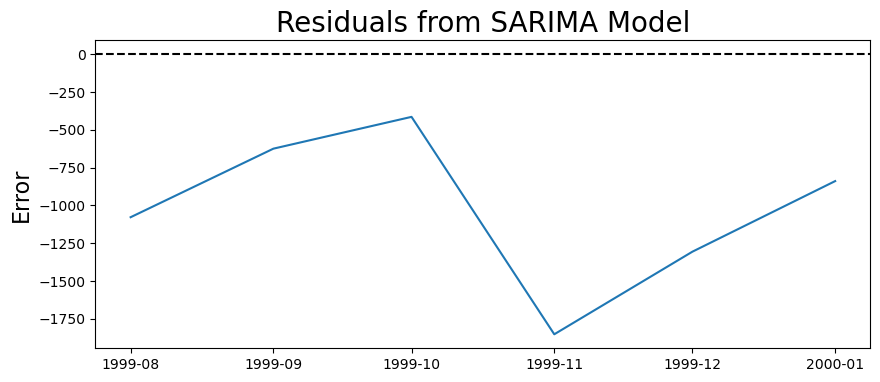

In [32]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

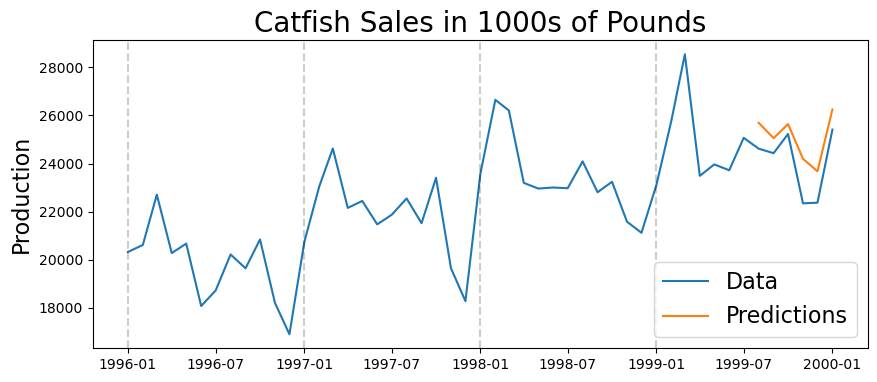

In [33]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [34]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_series)),4))

Mean Absolute Percent Error: 0.0433


In [35]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3047197056494


# Using the Rolling Forecast Origin

In [36]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/tmp/ipykernel_132322/2775757124.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25695.47730286]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarim

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88111D+00    |proj g|=  1.26626D+00

At iterate    5    f=  8.57512D+00    |proj g|=  3.01676D-01

At iterate   10    f=  8.55001D+00    |proj g|=  1.38247D-03

At iterate   15    f=  8.55001D+00    |proj g|=  1.09204D-03

At iterate   20    f=  8.54985D+00    |proj g|=  1.51809D-02

At iterate   25    f=  8.54232D+00    |proj g|=  1.11473D-01

At iterate   30    f=  8.51785D+00    |proj g|=  1.03001D-02

At iterate   35    f=  8.51071D+00    |proj g|=  1.52217D-01

At iterate   40    f=  8.50313D+00    |proj g|=  9.28004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86898D+00    |proj g|=  1.22534D+00

At iterate    5    f=  8.57652D+00    |proj g|=  2.96239D-01

At iterate   10    f=  8.55121D+00    |proj g|=  1.26845D-03

At iterate   15    f=  8.55121D+00    |proj g|=  1.11440D-03

At iterate   20    f=  8.55103D+00    |proj g|=  2.17354D-02

At iterate   25    f=  8.53754D+00    |proj g|=  1.00837D-01

At iterate   30    f=  8.51618D+00    |proj g|=  1.68371D-02

At iterate   35    f=  8.51176D+00    |proj g|=  1.44595D-01

At iterate   40    f=  8.50171D+00    |proj g|=  1.96765D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projec

/tmp/ipykernel_132322/2775757124.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/tmp/ipykernel_132322/2775757124.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting se

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22686D+00    |proj g|=  1.12863D+00

At iterate    5    f=  8.49639D+00    |proj g|=  1.08333D-02

At iterate   10    f=  8.49439D+00    |proj g|=  1.34288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.520D-05   8.494D+00
  F =   8.4943895879515665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/tmp/ipykernel_132322/2775757124.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   15    f=  8.50709D+00    |proj g|=  1.42257D-04

At iterate   20    f=  8.50704D+00    |proj g|=  3.77341D-03

At iterate   25    f=  8.49651D+00    |proj g|=  5.62584D-02

At iterate   30    f=  8.48985D+00    |proj g|=  6.99679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     73      2     0     0   1.302D-05   8.490D+00
  F =   8.4898467445222412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/tmp/ipykernel_132322/2775757124.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/tmp/ipykernel_132322/2775757124.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [37]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

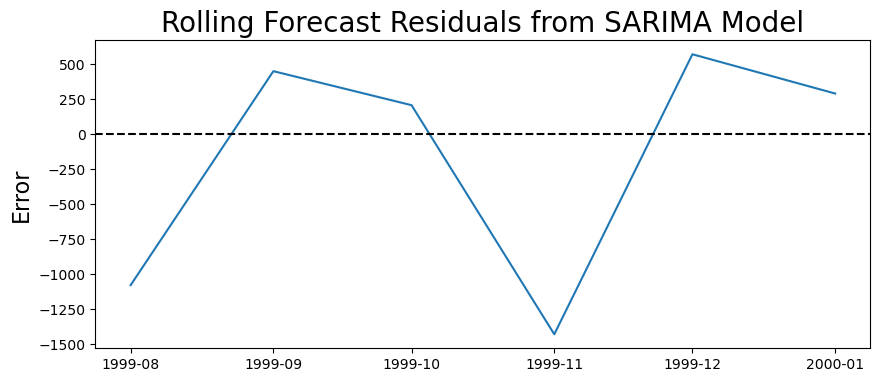

In [38]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

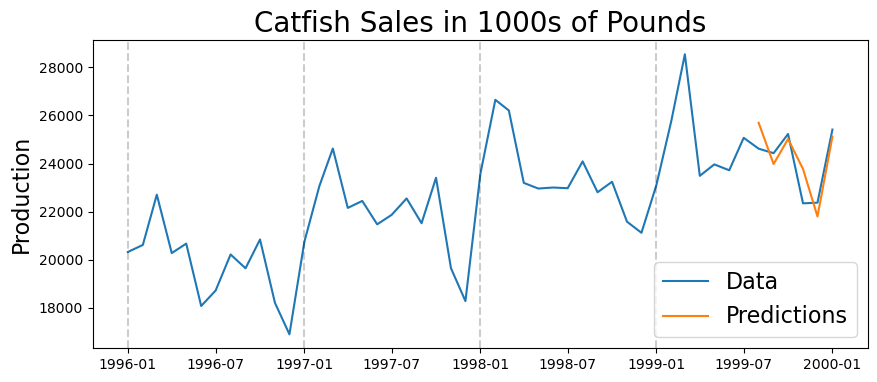

In [39]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [40]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0286


In [41]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 802.3547518758006
